## Encontrar melhor caminho entre clientes.

Neste projeto, abordamos um desafio complexo e fascinante na área de otimização de redes: encontrar a melhor combinação de distribuição de rede que respeita restrições específicas de conectividade. O objetivo principal foi desenvolver uma solução que não apenas minimizasse o custo total da rede, mas também aderisse a critérios rigorosos: cada nó na rede pode se conectar a no máximo quatro outros nós, e cada nó deve receber conexão de no máximo um nó. Além disso, foi essencial garantir que todos os nós estivessem conectados, direta ou indiretamente, a um ponto inicial designado, formando uma estrutura coesa e eficiente.

O problema apresenta desafios significativos devido à necessidade de balancear a eficiência da rede — em termos de custo e distribuição — com as restrições impostas. Para enfrentar esses desafios, empregamos técnicas de otimização de grafos, utilizando a ideia de árvores geradoras mínimas (MST) como ponto de partida. O algoritmo de árvore geradora mínima foi adaptado e refinado para cumprir as restrições específicas do problema, levando a uma solução personalizada que atende às necessidades únicas de distribuição de rede.

Este repositório contém o código e a documentação relacionada ao desenvolvimento dessa solução. Através de uma abordagem iterativa e heurísticas cuidadosamente projetadas, conseguimos construir uma ferramenta que não apenas resolve o problema de otimização de rede de forma eficaz, mas também serve como um exemplo valioso de como técnicas avançadas de ciência da computação e análise de redes podem ser aplicadas para solucionar problemas práticos e teóricos no campo da engenharia de redes.

In [59]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Definir a função para calcular a distância entre dois pontos geográficos
def calculate_distance(lat1, lon1, lat2, lon2):
    # Aproximação da Terra como esfera
    # Raio da Terra em metros
    R = 6371000
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2.0) ** 2 + \
        np.cos(phi1) * np.cos(phi2) * \
        np.sin(delta_lambda/2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

# Criar o grafo
G = nx.Graph()

# Gerar dados fictícios para 20 clientes
np.random.seed(0)  # Para reprodutibilidade
base_lat = -23.550520  # Aproximadamente a latitude de São Paulo, Brasil
base_lon = -46.633308  # Aproximadamente a longitude de São Paulo, Brasil
qtde_nodes = 50

# Variar em torno da base para gerar pontos próximos
lats = base_lat + np.random.uniform(-0.005, 0.005, qtde_nodes)
lons = base_lon + np.random.uniform(-0.005, 0.005, qtde_nodes)

# Adicionar os nós ao grafo com seus atributos
for i in range(qtde_nodes):
    G.add_node(i, ID=i, lat=lats[i], lon=lons[i])

# Conectar nós que estão a menos de 300 metros um do outro
for i in range(qtde_nodes):
    for j in range(i + 1, qtde_nodes):
        if calculate_distance(G.nodes[i]['lat'], G.nodes[i]['lon'], G.nodes[j]['lat'], G.nodes[j]['lon']) <= 300:
            G.add_edge(i, j)




#### Desenhar o grafo -- Apresenta todas as conexões possíveis!

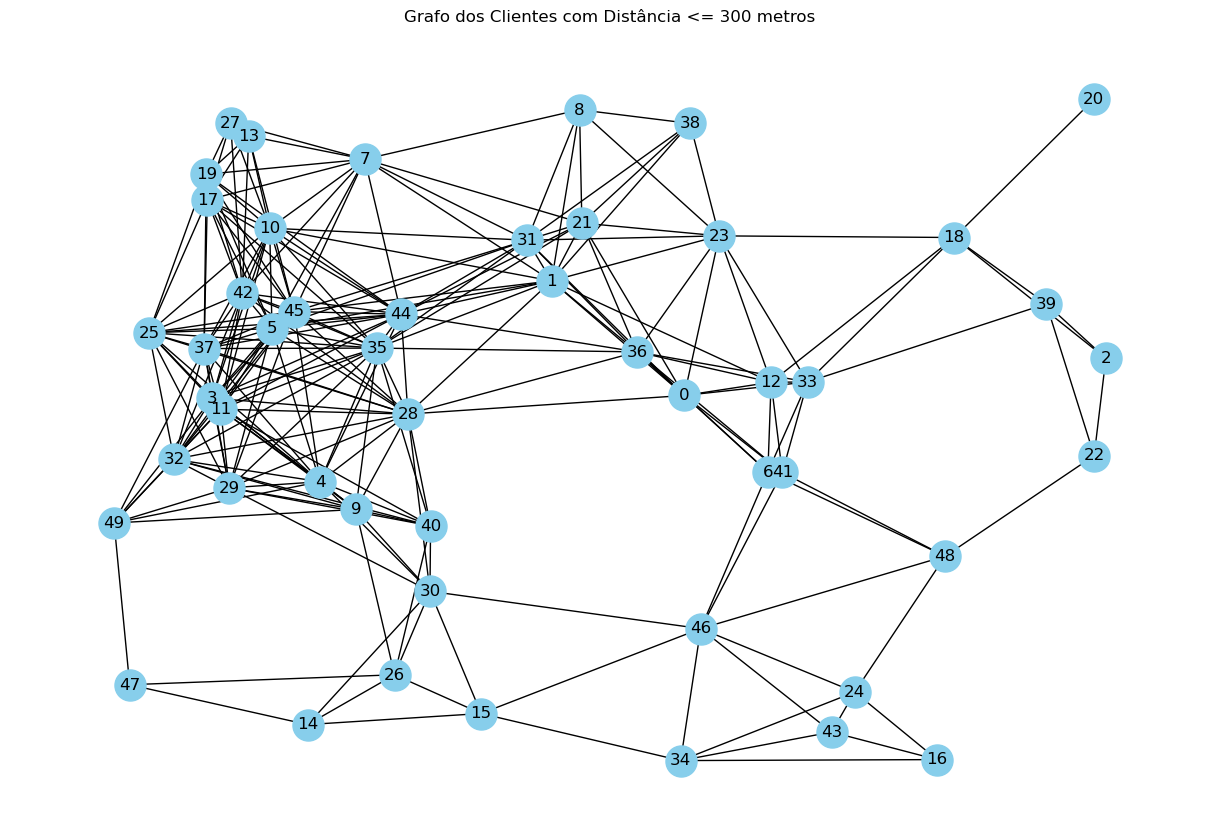

In [61]:

plt.figure(figsize=(12, 8))
pos = {i: (G.nodes[i]['lon'], G.nodes[i]['lat']) for i in range(qtde_nodes)}
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='k')
plt.title("Grafo dos Clientes com Distância <= 300 metros")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

#### Atualizar o grafo para incluir o peso das arestas com base na distância (dados fictícios)

In [51]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Atualizar o grafo para incluir o peso das arestas com base na distância
for i, j in G.edges():
    lat_i, lon_i = G.nodes[i]['lat'], G.nodes[i]['lon']
    lat_j, lon_j = G.nodes[j]['lat'], G.nodes[j]['lon']
    distance = calculate_distance(lat_i, lon_i, lat_j, lon_j)
    G.edges[i, j]['distance'] = distance

# Definir o custo por metro
custo_por_metro_network = 20

# Recalcular a árvore geradora mínima com os pesos atualizados
mst = nx.minimum_spanning_tree(G, weight='distance')

# Recalcular o custo total da árvore geradora mínima
total_distance = sum(nx.get_edge_attributes(mst, 'distance').values())
total_cost = total_distance * custo_por_metro_network

In [54]:
print(f"Custo máximo de construção de rede: R${str(round(total_cost, 2)).replace('.',',')}")

Custo máximo de construção de rede: R$106701,49


#### Desenhar a árvore geradora mínima -- Sem nenhuma restrição de limite de expansões!

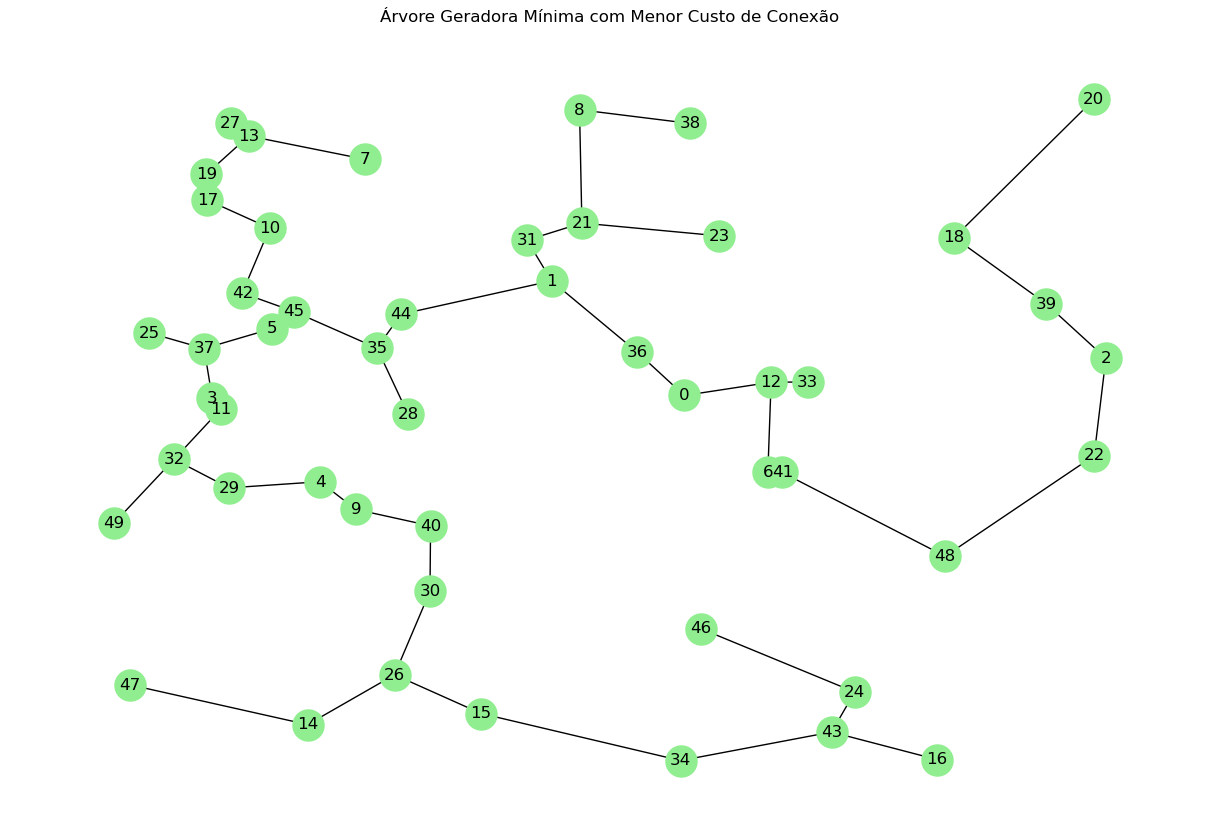

In [55]:

plt.figure(figsize=(12, 8))
pos = {i: (G.nodes[i]['lon'], G.nodes[i]['lat']) for i in G.nodes()}
nx.draw(mst, pos, with_labels=True, node_color='lightgreen', node_size=500, edge_color='k')
plt.title("Árvore Geradora Mínima com Menor Custo de Conexão")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


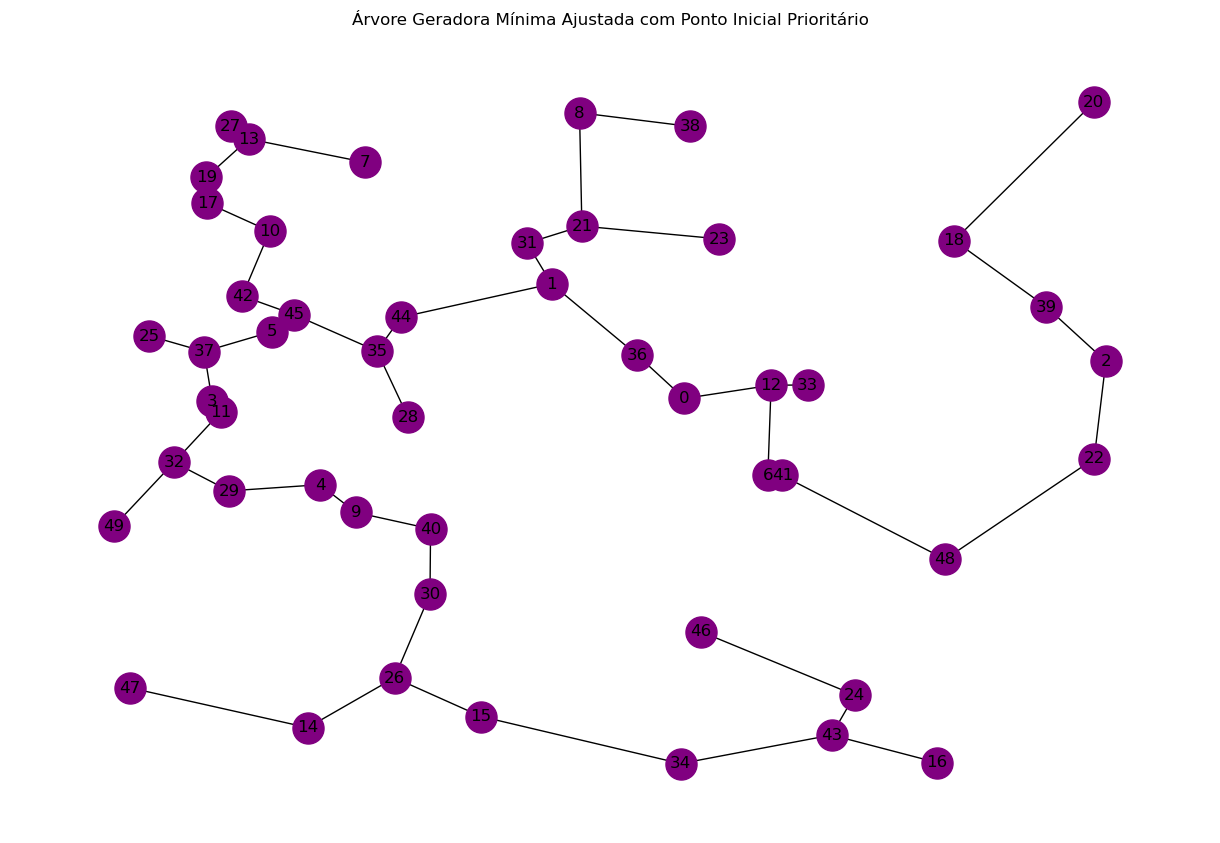

In [46]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Supondo que G é o seu grafo original já definido anteriormente

# Gerar a árvore geradora mínima a partir do ponto inicial
mst = nx.minimum_spanning_tree(G, weight='distance')

# Função para ajustar a MST com ponto inicial prioritário
def adjust_mst_with_initial_point(mst, initial_point, max_outbound=5):
    # Criar uma cópia do MST para modificar
    adjusted_mst = mst.copy()
    
    # Inicializar um dicionário para acompanhar as conexões de saída e entrada
    outbound_connections = defaultdict(int)
    inbound_connections = defaultdict(list)
    
    for node in mst.nodes():
        for target in mst[node]:
            outbound_connections[node] += 1
            inbound_connections[target].append(node)
    
    # Identificar e remover arestas que excedem a restrição de saída, exceto para o ponto inicial
    for node, connections in outbound_connections.items():
        if connections > max_outbound and node != initial_point:
            connected_nodes = list(adjusted_mst[node])
            while outbound_connections[node] > max_outbound:
                # Simplificação: remover conexões até atender a restrição
                target = connected_nodes.pop()
                if adjusted_mst.has_edge(node, target):
                    adjusted_mst.remove_edge(node, target)
                    outbound_connections[node] -= 1
                    inbound_connections[target].remove(node)
    
    # Verificar se todos os nós estão conectados ao ponto inicial direta ou indiretamente
    connected_to_initial = nx.descendants(adjusted_mst, initial_point) | {initial_point}
    for node in list(adjusted_mst.nodes()):
        if node not in connected_to_initial:
            # Remover nó não conectado
            adjusted_mst.remove_node(node)
    
    return adjusted_mst

# Definir o ponto inicial (por exemplo, o nó com ID 0)
ponto_inicial = 5

# Ajustar a MST considerando o ponto inicial como prioritário
adjusted_mst_with_initial_point = adjust_mst_with_initial_point(mst, ponto_inicial)

# Desenhar a MST ajustada com o ponto inicial como prioritário
plt.figure(figsize=(12, 8))
pos = {i: (G.nodes[i]['lon'], G.nodes[i]['lat']) for i in G.nodes() if i in adjusted_mst_with_initial_point.nodes()}
nx.draw(adjusted_mst_with_initial_point, pos, with_labels=True, node_color='purple', node_size=500, edge_color='k')
plt.title("Árvore Geradora Mínima Ajustada com Ponto Inicial Prioritário")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()
